In [52]:
#First lets import some usefull packages and functions

import pandas as pd
import numpy as np
import pylab as plt
import itertools as itr
import seaborn as sns
from sklearn.linear_model import LinearRegression
from scipy import stats as st
from matplotlib_venn import venn3, venn3_circles
from matplotlib_venn import venn2, venn2_circles
pd.options.display.max_seq_items = 2000 #print long list

# Data Cleaning

In [53]:
#Use pandas to load up csv's
df1 = pd.read_csv('hfi_cc_2018.csv') #freedom data
df2 = pd.read_csv('2016.csv') #happiness data

'hfi_cc_2018.csv' is the human freedom index data up to 2016 and '2016.csv' is the happiness report data for 2016. Since the years may be diffrent we may want to filter the hfi data to only have data from 2016.

In [54]:
#edit df1 to get only 2016 observations
df1 = df1[df1["year"]==2016]

#rename column in df1/2 for common country column title by just making a variable
comn = 'country'
df1 = df1.rename(columns = {'countries':comn})
df2 = df2.rename(columns = {'Country':comn})

#lowercase comn column of each 
df1[comn] = df1[comn].apply(lambda x: x.lower())
df2[comn] = df2[comn].apply(lambda x: x.lower())

Now that the names are somewhat similar, I want to see how many countries were included in both data sets, more precisely I want to see how many countries were only included in one data set.

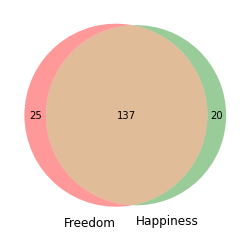

In [55]:
#compare how much overlap there is among data in terms of country names
set1_u = set(df1[comn]) #Freedom names
set2_u = set(df2[comn]) #Happiness names
venn2([set1_u, set2_u],('Freedom','Happiness'))
plt.savefig('Initcomparename.svg')
plt.show()

Since the amount of countries excluded by atleast one of the datasets is so small, I looked through the csv and just noted some countries that had diffrent names

In [56]:
#replace values in df1 as needed to stop some confusion
df1[comn] = df1[comn].replace({'yemen, rep.':'yemen',
            'korea, south':'south korea',
            'czech rep.':'czech republic',
            'slovak rep.':'slovakia',
            'dominican rep.':'dominican republic',
            'congo, rep. of':'congo (brazzaville)',
            'kyrgyz republic':'kyrgyzstan',
            'congo, dem. r.':'congo (kinshasa)',
            "cote d'ivoire":'ivory coast'})

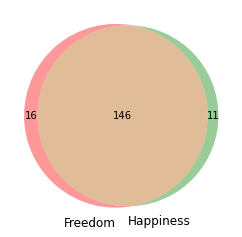

In [57]:
#Now compare how much overlap there is among df1/2 in terms of country names after replacing renaming some items
set1_u = set(df1[comn])
set2_u = set(df2[comn])
venn2([set1_u, set2_u],('Freedom','Happiness'))
plt.savefig('changednamecompare.svg')
plt.show()

In [58]:
#Lets get the intersection of the names
inter = set1_u & set2_u

In [59]:
#now lets cutthe two dataframes so they have common names
inter_df_1 = df1[df1[comn].isin(inter)]
inter_df_2 = df2[df2[comn].isin(inter)]

In [60]:
#merge the two dataframe
df_t = pd.merge(inter_df_1,inter_df_2,on=comn)
df_t.head()

,year,ISO_code,country,region,pf_rol_procedural,pf_rol_civil,pf_rol_criminal,pf_rol,pf_ss_homicide,pf_ss_disappearances_disap,...,Happiness Score,Lower Confidence Interval,Upper Confidence Interval,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Dystopia Residual
0,2016,ALB,albania,Eastern Europe,6.661503,4.547244,4.666508,5.291752,8.920429,10.0,...,4.655,4.546,4.764,0.95530,0.50163,0.73007,0.31866,0.05301,0.16840,1.92816
1,2016,DZA,algeria,Middle East & North Africa,NaN,NaN,NaN,3.819566,9.456254,10.0,...,6.355,6.227,6.483,1.05266,0.83309,0.61804,0.21006,0.16157,0.07044,3.40904
2,2016,AGO,angola,Sub-Saharan Africa,NaN,NaN,NaN,3.451814,8.060260,5.0,...,3.866,3.753,3.979,0.84731,0.66366,0.04991,0.00589,0.08434,0.12071,2.09459
3,2016,ARG,argentina,Latin America & the Caribbean,7.098483,5.791960,4.343930,5.744791,7.622974,10.0,...,6.650,6.560,6.740,1.15137,1.06612,0.69711,0.42284,0.07296,0.10989,3.12985
4,2016,ARM,armenia,Caucasus & Central Asia,NaN,NaN,NaN,5.003205,8.808750,10.0,...,4.360,4.266,4.454,0.86086,0.62477,0.64083,0.14037,0.03616,0.07793,1.97864


There are still some problems:
- Two columns denoting regions
- Some columns denote a ranking (this being a problem will be explained later)
- Some columns have clearly categorical and not quantitative data (will also be explained later)
- Since we originally had two data sets we merged there will naturally be nan values, potentialy to many

First take care of the easy problems

In [61]:
#delete redundant Region column
del df_t['Region']

#It will be usefull to exlcude the ranking variables
ord_var = ['pf_rank','ef_rank','hf_rank','Happiness Rank']
df_t = df_t.drop(ord_var,1)


Now for the to many nans problem

In [62]:
#Next we might want to see if there are any variables that have far to many empty values to use reliably
cols = df_t.columns

tups = []
#loop over the columns
for col in cols:
    #select current column
    curr_col = df_t[col]
    #to pass something into np.nan() it must be a float
    if curr_col.dtype != 'float64':
        continue
    #get number of nan types in the current column
    null_count = sum(1 for x in curr_col if np.isnan(x)==True)
    tups.append((col,null_count))
    

#tups is now an array of tuples (x,y) where x is the variable name and y is the number of nan under that variable
#now we can manipulate the tups array to give us a list of variables with to many nan

#declare the threshold for how many nones is to many
nan_thresh = 10

#select the variables that have to many nans
bad_var = [x[0] for x in tups if x[1]>=nan_thresh]

#drop variables with to many nan
df_t = df_t.drop(bad_var,1)

df_t.head()

,year,ISO_code,country,region,pf_rol,pf_ss_homicide,pf_ss_disappearances_disap,pf_ss_disappearances_violent,pf_ss_disappearances_organized,pf_ss_disappearances_fatalities,...,Happiness Score,Lower Confidence Interval,Upper Confidence Interval,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Dystopia Residual
0,2016,ALB,albania,Eastern Europe,5.291752,8.920429,10.0,10.00000,10.0,10.000000,...,4.655,4.546,4.764,0.95530,0.50163,0.73007,0.31866,0.05301,0.16840,1.92816
1,2016,DZA,algeria,Middle East & North Africa,3.819566,9.456254,10.0,9.29403,5.0,9.926119,...,6.355,6.227,6.483,1.05266,0.83309,0.61804,0.21006,0.16157,0.07044,3.40904
2,2016,AGO,angola,Sub-Saharan Africa,3.451814,8.060260,5.0,10.00000,7.5,10.000000,...,3.866,3.753,3.979,0.84731,0.66366,0.04991,0.00589,0.08434,0.12071,2.09459
3,2016,ARG,argentina,Latin America & the Caribbean,5.744791,7.622974,10.0,10.00000,7.5,10.000000,...,6.650,6.560,6.740,1.15137,1.06612,0.69711,0.42284,0.07296,0.10989,3.12985
4,2016,ARM,armenia,Caucasus & Central Asia,5.003205,8.808750,10.0,10.00000,7.5,9.316196,...,4.360,4.266,4.454,0.86086,0.62477,0.64083,0.14037,0.03616,0.07793,1.97864


Export some of the head to convert the html into a png later

In [63]:
df_t.head()[['year','ISO_code','country','region','Happiness Score','Freedom','Generosity','Dystopia Residual']].to_html('CombinedTableHead.html')

In [64]:
#it will be usefull to have a quick way to get only quantatitive data from a frame
def num_only(df):
    str_var = ['region', 'country', 'ISO_code', 'year']
    use = df.drop(str_var,1)
    return(use)

#simple statistical range function
def simp_range(data):
    return np.max(data) - np.min(data)

# Idea 1:normality score
For a region we may utilize the shapiro wilks normality test to score a region based on how many variables are normal in that region

In [65]:
#this function takes in dataframe and counts number of normal variables
def norm_vars(data):
    #we must consider Nan
    #it may be better to remove rows since in the end we want the score to be porpotional to number of variables
    #so we dont want to eliminate variables of the bat
    nonans = data.dropna()
    #now lets eliminate any text value variables
    nostrings = num_only(nonans)
    
    norm_count = 0
    for col in nostrings.columns:
        points = nostrings[col]
        #if we have less than 3 points or has zero range assume the p_val is 0
        if (len(points)<=3) or (simp_range(points)==0):
            p_val = 0
        #otherwise run test
        else:
            test_stat = st.shapiro(points)
            p_val = test_stat[1]
        #based on p_val decide if the variable is normal
        if p_val > 0.5:
            norm_count += 1
    return(norm_count)

# Idea 2:Dimensional concentration
take each numerical variable in a dataset and allow it to be a coordinate for some point in n dimensional space. compare the average distances between all points created from a dataframe

In [66]:
#simple function to convert the rows of a dataframe into values of R^n
def points(data):
    #drop na, reset index, and only use categorical data
    t = num_only(data.dropna().reset_index(drop=True))
    #use select the datframes values
    points = t.values
    return(points)


#this function will take in a datafrema convert each observation into  n-tuples and return the average 
#distance betweem all n-tuples
def average_dist(data):
    point_list = points(data)
    #get combinations using itertools
    combs = itr.combinations(point_list,2)
    distances = [np.linalg.norm(p1-p2) for p1,p2 in combs]

    ret = np.mean(distances)
    return(ret)

# Idea 3 comparing correlated variables
Avergaing the $R^2$ values among every pair of 2 variables within a dataset

In [67]:
#function that will take in a dataframe, and return the average r^2 value over thw whole df
def lin_reg(data):
    use = num_only(data.dropna())

    #get combinations of usbale variables
    combos = list(itr.permutations(use.columns,2))
    
    col_nam = ["X","Y","R^2"]
    dats = []
    
    for var_a,var_b in combos:
        #get the x,y data
        #note the reshape
        x = use[var_a].values.reshape(-1,1)
        y = use[var_b].values
        
        r_sqr = LinearRegression().fit(x,y).score(x,y)
        dats.append([var_a,var_b,r_sqr])
    
    #make the regression data into a dataframe and sort the values and reset the index
    df = pd.DataFrame(dats,columns = col_nam).sort_values('R^2',ascending=False).reset_index(drop = True)
    #get the average
    average = np.mean(df['R^2'])
    #return avergae r^2 value
    return average

# Scoring across diffrent Regions
Now that we have some ideas about how to define predictibilty we can see what diffrent regions score

In [68]:
#The following is tabulated information about the regions we have and the measures weve been able to come up with so far
regions = np.unique(df_t['region'])

vals = []
for region in regions:
    #narrow the dataframe to only have dat for a given region
    dt = df_t[df_t["region"]==region]
    
    #calculate some stats based on ideas
    #normality score, average distance, average r^2
    norm_sc = norm_vars(dt)
    avg_dist = average_dist(dt)
    avg_r_sq = lin_reg(dt)
    
    tup = [region,norm_sc,avg_dist,avg_r_sq]
    #append this region data to vals
    vals.append(tup)
    
col_name = ['region','norm score','average distance','average R^2']
scores = pd.DataFrame(vals,columns = col_name)
scores

,region,norm score,average distance,average R^2
0,Caucasus & Central Asia,32,20.520311,0.283275
1,East Asia,30,26.550563,0.417982
2,Eastern Europe,18,18.362383,0.174683
3,Latin America & the Caribbean,17,23.080860,0.118738
4,Middle East & North Africa,17,32.568120,0.164118
5,North America,0,11.421435,0.790332
6,Oceania,0,11.522955,0.775578
7,South Asia,18,28.380042,0.192342
8,Sub-Saharan Africa,16,28.195702,0.095097
9,Western Europe,11,14.060909,0.257533


Lets clean some of these results a little by normalizing the scores since the data seems to have varying scales

In [69]:
#normalization function
def normalize(val,array):
    min_ = np.min(array)
    max_ = np.max(array)
    new = (val - min_)/(max_-min_)
    return new

In [70]:
#appedn the standard scores to the dataframe
scores["Nrmlzd norm score"] = [normalize(x,scores["norm score"]) for x in scores["norm score"]]
scores["Nrmlzd Avg Dist"] = [normalize(x,scores["average distance"]) for x in scores["average distance"]]
scores["Nrmlzd Avg R^2"] = [normalize(x,scores["average R^2"]) for x in scores["average R^2"]]

scores

,region,norm score,average distance,average R^2,Nrmlzd norm score,Nrmlzd Avg Dist,Nrmlzd Avg R^2
0,Caucasus & Central Asia,32,20.520311,0.283275,1.00000,0.430274,0.270669
1,East Asia,30,26.550563,0.417982,0.93750,0.715437,0.464425
2,Eastern Europe,18,18.362383,0.174683,0.56250,0.328229,0.114473
3,Latin America & the Caribbean,17,23.080860,0.118738,0.53125,0.551359,0.034005
4,Middle East & North Africa,17,32.568120,0.164118,0.53125,1.000000,0.099277
5,North America,0,11.421435,0.790332,0.00000,0.000000,1.000000
6,Oceania,0,11.522955,0.775578,0.00000,0.004801,0.978778
7,South Asia,18,28.380042,0.192342,0.56250,0.801951,0.139874
8,Sub-Saharan Africa,16,28.195702,0.095097,0.50000,0.793234,0.000000
9,Western Europe,11,14.060909,0.257533,0.34375,0.124817,0.233642


Export as html to use as png later

In [71]:
scores.to_html('Scores.html')

# Combining the score ideas into a single index¶
The formula for the final predictibility index will now be,

$$S(\text{reg}_i, \text{reg}_j) = \bigg(\frac{1}{2}|N_{\text{reg}_i}-N_{\text{reg}_j}| + |D_{\text{reg}_i}-D_{\text{reg}_j}|+10|R_{\text{reg}_i}-R_{\text{reg}_j}|\bigg)^{-1}$$

Where, 
- $N_{\text{reg}_n}$ is the Normalized norm score of the $n^{th}$ region
- $D_{\text{reg}_n}$ is the Normalized average distance among datapoints within the $n^{th}$ region
- $R_{\text{reg}_n}$ is the Normalized average $r^2$ among datapoints in the $n^{th}$ region

Note, $S(\text{reg}_i, \text{reg}_i) := 1$ and $S(\text{reg}_i, \text{reg}_j)=S(\text{reg}_j, \text{reg}_i)$

In [72]:
#function to use the defined measures to compare two regons based on the scores dataframe
def disimi(reg1,reg2):
    #get the regions data
    X1 = scores[scores["region"]==reg1]
    X2 = scores[scores["region"]==reg2]
    
    #pick out the normalized norm score and find the diffrence
    x1_norm = X1["Nrmlzd norm score"].values
    x2_norm = X2["Nrmlzd norm score"].values
    norm_diff = np.absolute(x1_norm - x2_norm)
    
    #get the diffrence between average distances
    x1_avgd_norm = X1["Nrmlzd Avg Dist"].values
    x2_avgd_norm = X2["Nrmlzd Avg Dist"].values
    avgd_diff = np.absolute(x1_avgd_norm - x2_avgd_norm)
    
    #get the diffrence between the average r^2
    x1_r_sq = X1["Nrmlzd Avg R^2"].values
    x2_r_sq = X2["Nrmlzd Avg R^2"].values
    avg_r_diff = np.absolute(x1_r_sq - x2_r_sq)
    
    #scale the scores
    norm_sc_comp = norm_diff*(.5)
    avg_dist_comp = avgd_diff
    avg_r_comp = avg_r_diff*(10)
    
    tot = (norm_sc_comp + avg_dist_comp + avg_r_comp)[0]
    if tot==0:
        ret = 1
    else:
        ret = 1/tot
    return(ret)

In [73]:
label = ['region']
regions = list(np.unique(df_t['region']))

In [74]:
across = label + regions
verticle = regions

vals = []
for i in range(len(verticle)):
    left = verticle[i]
    other = []
    for j in range(len(regions)):
        c = disimi(regions[j],left)
        other.append(c)
    entire = [left] + other
    vals.append(entire)
    
simi_matrix = pd.DataFrame(vals,columns = across)
simi_matrix

,region,Caucasus & Central Asia,East Asia,Eastern Europe,Latin America & the Caribbean,Middle East & North Africa,North America,Oceania,South Asia,Sub-Saharan Africa,Western Europe
0,Caucasus & Central Asia,1.000000,0.443660,0.531138,0.367363,0.397138,0.121601,0.124898,0.526765,0.301237,0.996165
1,East Asia,0.443660,1.000000,0.245445,0.214068,0.241594,0.152907,0.158155,0.284129,0.202396,0.312957
2,Eastern Europe,0.531138,0.245445,1.000000,0.958369,1.191386,0.105655,0.108135,1.374144,0.609389,0.664684
3,Latin America & the Caribbean,0.367363,0.214068,0.958369,1.000000,0.907966,0.095448,0.097467,0.754772,1.673503,0.397351
4,Middle East & North Africa,0.397138,0.241594,1.191386,0.907966,1.000000,0.097344,0.099445,1.613842,0.822935,0.432417
5,North America,0.121601,0.152907,0.105655,0.095448,0.097344,1.000000,4.607812,0.103258,0.090553,0.125624
6,Oceania,0.124898,0.158155,0.108135,0.097467,0.099445,4.607812,1.000000,0.105625,0.092368,0.129145
7,South Asia,0.526765,0.284129,1.374144,0.754772,1.613842,0.103258,0.105625,1.000000,0.695070,0.579981
8,Sub-Saharan Africa,0.301237,0.202396,0.609389,1.673503,0.822935,0.090553,0.092368,0.695070,1.000000,0.324363
9,Western Europe,0.996165,0.312957,0.664684,0.397351,0.432417,0.125624,0.129145,0.579981,0.324363,1.000000


In [75]:
#edit the index type as to make the dataframe cleaner
simi_matrix.set_index('region',inplace=True)

In [76]:
simi_matrix

,Caucasus & Central Asia,East Asia,Eastern Europe,Latin America & the Caribbean,Middle East & North Africa,North America,Oceania,South Asia,Sub-Saharan Africa,Western Europe
region,,,,,,,,,,
Caucasus & Central Asia,1.000000,0.443660,0.531138,0.367363,0.397138,0.121601,0.124898,0.526765,0.301237,0.996165
East Asia,0.443660,1.000000,0.245445,0.214068,0.241594,0.152907,0.158155,0.284129,0.202396,0.312957
Eastern Europe,0.531138,0.245445,1.000000,0.958369,1.191386,0.105655,0.108135,1.374144,0.609389,0.664684
Latin America & the Caribbean,0.367363,0.214068,0.958369,1.000000,0.907966,0.095448,0.097467,0.754772,1.673503,0.397351
Middle East & North Africa,0.397138,0.241594,1.191386,0.907966,1.000000,0.097344,0.099445,1.613842,0.822935,0.432417
North America,0.121601,0.152907,0.105655,0.095448,0.097344,1.000000,4.607812,0.103258,0.090553,0.125624
Oceania,0.124898,0.158155,0.108135,0.097467,0.099445,4.607812,1.000000,0.105625,0.092368,0.129145
South Asia,0.526765,0.284129,1.374144,0.754772,1.613842,0.103258,0.105625,1.000000,0.695070,0.579981
Sub-Saharan Africa,0.301237,0.202396,0.609389,1.673503,0.822935,0.090553,0.092368,0.695070,1.000000,0.324363


In [77]:
#Export as html for later
simi_matrix.to_html('simi_matrix.html')

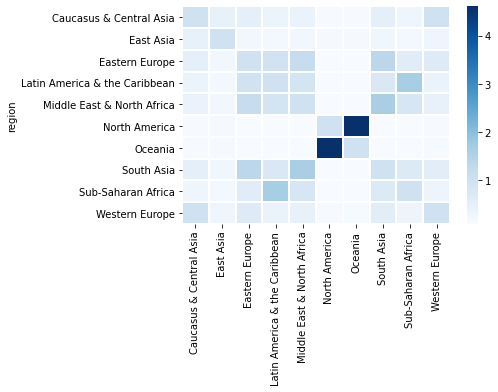

In [79]:
#Lets make a heat map to show a good visual
heat = sns.heatmap(simi_matrix,linewidths=1,cmap='Blues')
plt.savefig('heat.svg')